In [1]:
#!/usr/bin/env python

#-*- encoding: utf-8 

'''
                      ______   ___  __
                     / ___\ \ / / |/ /
                    | |    \ V /| ' / 
                    | |___  | | | . \ 
                     \____| |_| |_|\_\
 ==========================================================================
@author: Yekun Chai
@license: Center on Research of Intelligent Systems and Engineering, IA, CAS
@contact: chaiyekun@gmail.com
@file: DQN.py
@time: 3/21/19 4:06 PM
@desc： DQN   
               
'''


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(self, n_actions, n_features, learning_rate=.01, reward_decay=.9, e_greedy=.9,
                 replace_target_iter=300, memory_size=500, batch_size=32, e_greedy_increment=None,
                 output_graph=False):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning steps
        self.learn_step_counter = 0

        # initialize zero memory [s,a,r,s_]
        self.memory = np.zeros((self.memory_size, n_features*2 + 2))
        # consist of [target_net, eval_net]
        self._build_net()
        t_params = tf.get_collection("target_net_params")
        e_params = tf.get_collection("eval_net_params")
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []


    def _build_net(self):
        # -------------------- create evaluate net ------------------------ #
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name="s")
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name="Q_target")
        with tf.variable_scope("eval_net"):
            # c_names (collection_names) are the collections to store variables
            c_names = ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES]
            unit_l1 = 10
            w_initializer = tf.random_normal_initializer(0., .3)
            b_initializer = tf.constant_initializer(.1)

            # 1st layer
            with tf.variable_scope("l1"):
                w1 = tf.get_variable("w1", [self.n_features, unit_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable("b1", [1, unit_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # 2nd layer
            with tf.variable_scope("l2"):
                w2 = tf.get_variable("w2", [unit_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable("b2", [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope("loss"):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope("train"):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # -------------------- create target net ------------------------ #
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name="s_")

        with tf.variable_scope("target_net"):
            # c_names (collection_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # 1st layer
            with tf.variable_scope("l1"):
                w1 = tf.get_variable("w1", [self.n_features, unit_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable("b1", [1, unit_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # 2nd layer
            with tf.variable_scope("l2"):
                w2 = tf.get_variable("w2", [unit_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable("b2", [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2
    
    
    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with the new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print("\n target_param replaced \n")

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features]  # newest params
            }
        )

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target}
                                    )
        self.cost_his.append(self.cost)

        # increase epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel("Cost")
        plt.xlabel("training steps")
        plt.show()



[-0.5 -0.5] 2 0 [-0.25 -0.5 ]
[-0.25 -0.5 ] 2 0 [ 0.  -0.5]
[ 0.  -0.5] 2 0 [ 0.25 -0.5 ]
[ 0.25 -0.5 ] 1 0 [ 0.25 -0.25]
[ 0.25 -0.25] 1 0 [0.25 0.  ]

 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 


 target_param replaced 

game over


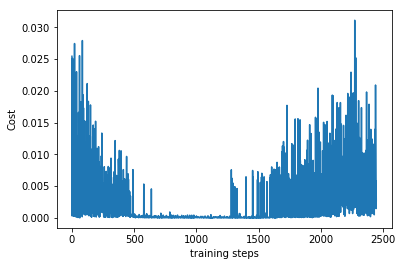

In [2]:
from maze_env import Maze

def run_maze():
    step = 0
    for episode in range(300):
        #init observation
        observation = env.reset()

        while True:
            # fresh env
            env.render()
            
            action = RL.choose_action(observation)

            
            observation_, reward, done = env.step(action)
            
            if step < 5:
                print(observation, action, reward, observation_)
            
            RL.store_transition(observation, action, reward, observation_)
            
            if (step>200) and (step%5==0):
                RL.learn()
            
            # swap observation
            observation = observation_
            
            if done: break
            step += 1

    print("game over")
    env.destroy()

    
env=Maze()
RL = DeepQNetwork(env.n_actions, env.n_features, learning_rate=.01, reward_decay=.9, e_greedy=.9,
                 replace_target_iter=200, memory_size=2000, output_graph=True)
env.after(100, run_maze)
env.mainloop()
RL.plot_cost()

In [1]:
# DQN modified version

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


# DQN off-policy
class DeepQNetwork:
    def __init__(self, n_actions, n_features, learning_rate=.01, reward_decay=.9, e_greedy=.9,
                 replace_target_iter=300, memory_size=500, batch_size=32, e_greedy_increment=None,
                 output_graph=False):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning steps
        self.learn_step_counter = 0

        # initialize zero memory [s,a,r,s_]
        self.memory = np.zeros((self.memory_size, n_features*2 + 2))
        # consist of [target_net, eval_net]
        self._build_net()
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="target_net")
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="eval_net")
        
        with tf.variable_scope("hard_replacement"):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []


    def _build_net(self):
        # -------------------- all inputs ------------------------ #
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name="s") # input state
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name="s_") # input next state
        self.r = tf.placeholder(tf.float32, [None,], name='r') # input reward
        self.a = tf.placeholder(tf.int32, [None,], name='a') # input action
        
        w_initializer = tf.random_normal_initializer(0., .3)
        b_initializer = tf.constant_initializer(.1)
        
        # -------------------- create eval net ------------------------ #

        with tf.variable_scope("eval_net"):
            e1 = tf.layers.dense(self.s, 20, tf.nn.relu, kernel_initializer=w_initializer, 
                                 bias_initializer=b_initializer, name="e1")
            self.q_eval = tf.layers.dense(e1, self.n_actions, kernel_initializer=w_initializer, bias_initializer=b_initializer, 
                                         name="q")
            
        # -------------------- create target net ------------------------ #
        with tf.variable_scope("target_net"):
            t1 = tf.layers.dense(self.s_, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                bias_initializer=b_initializer, name="t1")
            self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_initializer, 
                                         bias_initializer=b_initializer, name="t2")
        
        with tf.variable_scope("q_target"):
            q_target = self.r + self.gamma*tf.reduce_max(self.q_next, axis=1, name="Qmax_s_") # shape: (None,)
            self.q_target = tf.stop_gradient(q_target)
        
        with tf.variable_scope("q_eval"):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)
            
        with tf.variable_scope("loss"):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name="TD_error"))
        with tf.variable_scope("train"):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)


    
    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with the new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)
            print("\n target_param replaced \n")

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        # train eval network
        _, cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.a: batch_memory[:, self.n_features],
                                                self.r: batch_memory[:, self.n_features+1],
                                                self.s_: batch_memory[:, -self.n_features:],}
                                    )
        self.cost_his.append(cost)

        # increase epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel("Cost")
        plt.xlabel("training steps")
        plt.show()


[-0.5 -0.5] 3 0 [-0.5 -0.5]
[-0.5 -0.5] 3 0 [-0.5 -0.5]
[-0.5 -0.5] 3 0 [-0.5 -0.5]
[-0.5 -0.5] 3 0 [-0.5 -0.5]
[-0.5 -0.5] 3 0 [-0.5 -0.5]

 target_param replaced 


 target_param replaced 


 target_param replaced 

game over


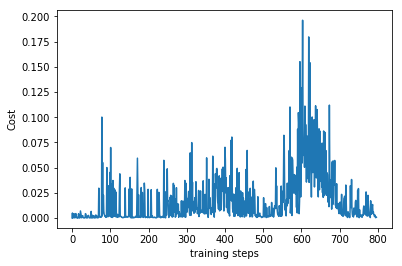

In [2]:
from maze_env import Maze
import matplotlib.pyplot as plt
%matplotlib inline

def run_maze():
    step = 0
    for episode in range(300):
        #init observation
        observation = env.reset()

        while True:
            # fresh env
            env.render()
            
            action = RL.choose_action(observation)

            
            observation_, reward, done = env.step(action)
            
            if step < 5:
                print(observation, action, reward, observation_)
            
            RL.store_transition(observation, action, reward, observation_)
            
            if (step>200) and (step%5==0):
                RL.learn()
            
            # swap observation
            observation = observation_
            
            if done: break
            step += 1

    print("game over")
    env.destroy()

    
env=Maze()
RL = DeepQNetwork(env.n_actions, env.n_features, output_graph=True)
env.after(100, run_maze)
env.mainloop()
RL.plot_cost()